In [24]:
from BayesBimodalTest import BayesBimodalTest
import numpy as np
import matplotlib.pyplot as plt
import seaborn
plt.rcParams['axes.labelsize'] = 22
%matplotlib inline

# How well can a Bayesian model comparison distinguish a bimodal distribution from a unimodal one?

## Bayesian bimodal test

The *evidence* for a unimodal Gaussian distribution, given some data is

$$ P(\textrm{unimodal }| \textrm{ data}) = \int_{\theta} \mathcal{N}(\textrm{ data }| \theta) P(\theta) d\theta $$

where $\theta=[\mu_0, \sigma_0]$ are the unimodal model parameters with priors $p(\theta)$.

For the bimodal Gaussian mixture model, we distinguish the model parameters by $\vartheta$, then define likelihood as

$$ P(\textrm{ data }| \textrm{ bimodal }, \vartheta) = 
   p\mathcal{N}(\textrm{ data }| \mu_A, \sigma_A) + (1-p)\mathcal{N}(\textrm{ data }| \mu_B, \sigma_B)
$$
such that $\vartheta=[\mu_A, \mu_B, \sigma_A, \sigma_B, p]$ where $p$ is the weights of the two mixture components.
The *evidence* for a bimodal Gaussian distribution, given some data is then

$$ P(\textrm{bimodal }| \textrm{ data}) = \int_{\vartheta} P(\textrm{ data }| \textrm{ bimodal }, \vartheta) P(\vartheta) d\theta $$

In the end, we want to calculate the Bayes factor:

$$
\mathrm{BF} = \frac{P(\textrm{bimodal }| \textrm{ data})}{P(\textrm{unimodal }| \textrm{ data})}
$$

which, if greater than one, provides evidence in favour of bimodality, and, if less than 1, provides evidence for the unimodal distribution. To do this I have written a python module [BayesBimodalTest](https://github.com/ga7g08/BayesBimodalTest) which is essentially a wrapper to use the [emcee](http://dan.iel.fm/emcee/current/) package to fit and and computer the evidence in each case.

### Example

Let's start with a simple example, we will produce some, obviously bimodal, data and compute the Bayes factor.

In [26]:
def GenerateBimodalData(muA, muB, sigmaA, sigmaB, p, N=1000):
    dataA = np.random.normal(muA, sigmaA, int(p*N))
    dataB = np.random.normal(muB, sigmaB, int((1-p)*N))
    return np.concatenate([dataA, dataB])

data = GenerateBimodalData(-2, 2, 1, 1, 0.9)
test = BayesBimodalTest(data, ntemps=30, nburn0=50, nburn=50, nprod=100, betamin=-8)

Firstly let's check that the MCMC chains have converged and that the resulting posteriors are sensible.

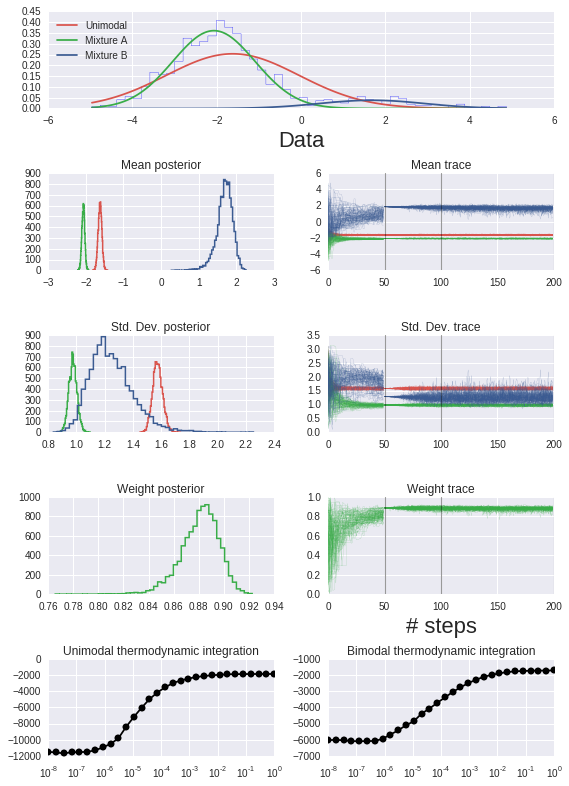

In [27]:
test.diagnostic_plot()

Okay so what is the Bayes factor? Note that this returns $\log_{10}(BF)$ along with an estimate of the error and the so-called Occam factor.

In [6]:
test.BayesFactor(print_result=True)

Bayes factor of 62.2494978009 +/- 1.14796064392
Occams factor is 1.47


In this instance the evidence is strongly in favour of bimodality, the errors are relatively small, and the Occam factor is small. The Occam factor provides information on how much the choice of prior (see the BayesBimodalTest implementation for details) effects the modal comparison. So in this case, we would need to change the prior by 60 orders of magnitude to change the conclusion of the model comparsion: the prior has no real effect on the conclusion. 

### Investigate the separation of means

Let us now investigate how well we can distinguish Bimodality depending on the separation of the means. Note that all the data here *is* bimodal by definition, but as the means approach each other it becomes more and more difficult to distinguish this.

For simplicity we will fix the weighting $p=0.5$, and give both distributions the same std. dev. $\sigma$. Then we will parameterise the whole system by the number of $\sigma$ separate the two means.

In [36]:
sigma_seps = np.linspace(3, 0.01, 40)
sigma = 1
p = 0.5

log10BF = []
log10BF_err = []
log10Occam = []
for ss in sigma_seps:
    muA = -0.5*ss
    muB = 0.5*ss
    data = GenerateBimodalData(muA, muB, sigma, sigma, p)
    test = BayesBimodalTest(data, ntemps=50, nburn0=50, nburn=50, nprod=50, betamin=-8)
    a, b, c, = test.BayesFactor(print_result=False)
    log10BF.append(a)
    log10BF_err.append(b)
    log10Occam.append(c)

We now plot the Bayes factor for this varying $\sigma$-separation. The measured values are shown as blue dots, with error bars. A red band indicates the Occam factor.

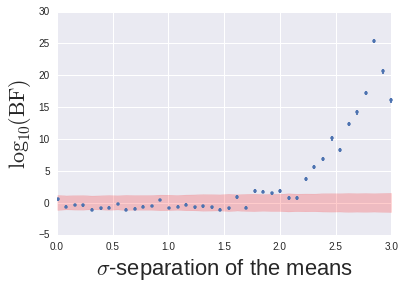

In [37]:
fig, ax = plt.subplots()

ax.errorbar(sigma_seps, log10BF, yerr=log10BF_err, fmt=".")
ax.set_xlabel("$\sigma$-separation of the means")
ax.set_ylabel(r"$\log_{10}(\mathrm{BF})$")
ax.fill_between(sigma_seps, log10Occam, -np.array(log10Occam), color="red", alpha=0.2)

plt.show()

This shows that, only for means separated above $\approx 2\sigma$, can the Bayes factor unamiguously rule out the  unimodal hypothesis. Below this it is difficult to rule out the Bimodal hypthesis, althrough in general the $\log_{10}(\textrm{BF})$ is generally negative (shown in a close-up below):

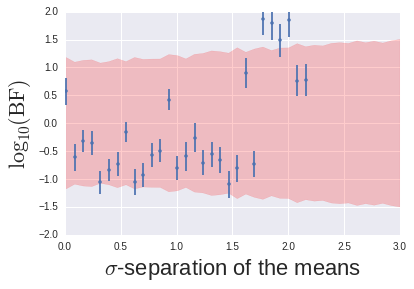

In [39]:
fig, ax = plt.subplots()

ax.errorbar(sigma_seps, log10BF, yerr=log10BF_err, fmt=".")
ax.set_xlabel("$\sigma$-separation of the means")
ax.set_ylabel(r"$\log_{10}(\mathrm{BF})$")
ax.fill_between(sigma_seps, log10Occam, -np.array(log10Occam), color="red", alpha=0.2)
ax.set_ylim(-2, 2)
plt.show()

The philosophy of "accepting" a unimodal hypothesis I will leave to more informed analysis.